# Text Summarization

Задача суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru

`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

Загрузим датасет и необходимые библиотеки

In [1]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [2]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa

     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 8.2 MB 29.7 MB/s 


In [3]:
!pip install youtokentome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 30.5 MB/s 


## Libraries

In [5]:
import copy
import json
import math
import torch
import razdel
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from rouge import Rouge
import youtokentome as yttm
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import minmax_scale
from nltk.translate.bleu_score import corpus_bleu
from train_model import punct_detokenize, postprocess
from sklearn.utils.class_weight import compute_class_weight
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

%matplotlib inline

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Dataset

Посмотрим на то, как устроен датасет

In [6]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [ ]:
def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r", encoding='utf-8') as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle(records)
    return records

In [ ]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [ ]:
def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        BLEU = corpus_bleu([[r] for r in references], predictions)
        print("BLEU: ", BLEU)
        return BLEU
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [ ]:
def train_bpe(records, model_path, vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w", encoding='utf-8') as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

### Словарь
Составим словарь для индексации токенов

In [ ]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [ ]:
def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    """
    Жадное построение oracle summary
    """
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences


def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']


def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, 
                                                                         calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Составление батчей

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True,
                 lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):

        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    _, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score,
                                                                        lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), 
                                        dtype=torch.long, device=self.device)
            tensor_outputs = torch.zeros((self.batch_size, max_sentences), 
                                         dtype=torch.float32, device=self.device)

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)
                tensor_outputs[i][len(outputs):] = 2  # we add index 2 for padding

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [ ]:
batch_size = 32  # set the batch size

In [ ]:
train_iterator = BatchIterator(ext_train_records, vocabulary, batch_size, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, batch_size, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, batch_size, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


In [ ]:
class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, num_layers=n_layers, dropout=dropout,
                                 bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        # inputs = [batch_size * seq num, seq_len]

        embedded = self.dropout_layer(self.embedding_layer(inputs))
        # embedded = [batch_size * seq num, seq_len, embedding_dim]

        outputs, _ = self.rnn_layer(embedded, hidden)
        # outputs = [batch_size * seq num, seq_len, hidden_size]

        sentences_embeddings = torch.mean(outputs, 1)
        # sentences_embeddings = [batch_size * seq num, hidden_size]

        return sentences_embeddings

In [ ]:
class SentenceTaggerRNN(nn.Module):
    def __init__(self, vocabulary_size, use_content=True, use_salience=True, use_novelty=True,
                 token_embedding_dim=128, sentence_encoder_hidden_size=256, hidden_size=256,
                 bidirectional=True, sentence_encoder_n_layers=2, sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True, n_layers=2, dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(input_size=vocabulary_size,
                                                   embedding_dim=token_embedding_dim,
                                                   hidden_size=sentence_encoder_hidden_size,
                                                   n_layers=sentence_encoder_n_layers,
                                                   dropout=sentence_encoder_dropout,
                                                   bidirectional=sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * num_directions, 1)
        self.document_linear_layer = nn.Linear(hidden_size * num_directions, hidden_size * num_directions)
        self.salience_linear_layer = nn.Linear(hidden_size * num_directions, hidden_size * num_directions)
        self.novelty_linear_layer = nn.Linear(hidden_size * num_directions, hidden_size * num_directions)
        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # inputs = [batch_size, seq num, seq_len]

        # parameters of the probability if some of them set to False
        content = 0
        salience = 0
        novelty = 0

        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)

        inputs = inputs.reshape(-1, tokens_count)
        # inputs = [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        # embedded_sentences = [batch_size * seq num, sentence_encoder_hidden_size]

        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # embedded_sentences = [batch_size * seq num, sentence_encoder_hidden_size] -> 
        # -> [batch_size, seq num, sentence_encoder_hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # outputs = [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # document_embedding = [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2)  # 1-representation
            # content = [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs,
                                 self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2)  # 2-representation
            # salience = [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            # predictions = [batch_size, seq num]

            # 0) initialize summary_representation by zeros
            summary_representation = torch.zeros(document_embedding.shape).to(device)
            # summary_representation = [batch_size, hidden_size]

            for sentence_num in range(sentences_count):
                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                sentence_num_state = outputs[:, sentence_num, :].unsqueeze(1)
                # sentence_num_state = [batch_size, 1, hidden_size]

                # 2) calculate novelty for current sentence
                # -h^T * W * tanh(s)
                # 3-representation
                novelty = -1 * torch.bmm(sentence_num_state,
                                         self.novelty_linear_layer(self.tanh_layer(summary_representation)).unsqueeze(2)).squeeze(2)
                # novelty = [batch_size, 1, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, 1, ]

                # 3) add novelty to predictions
                predictions[:, sentence_num] += novelty.squeeze(1)

                # 4) calculate probability for current sentence
                probability = torch.sigmoid(predictions[:, sentence_num])

                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation
                summary_representation += torch.mv(sentence_num_state.squeeze(1).T, probability)

        return content + salience + novelty

## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

In [ ]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927617


In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

In [ ]:
!gdown https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH -O train_model.py

import train_model
import imp 
imp.reload(train_model)
from train_model import train_with_logs

In [ ]:
N_EPOCHS = 10
CLIP = 5

def train(use_class_weights, model, N_EPOCHS, CLIP, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr)
    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        target = np.fromiter((i for batch in train_iterator for i in batch["outputs"].detach().cpu().numpy().flatten()), 
                             dtype=int)
        target = target[target != 2]
        weights = torch.tensor(compute_class_weight(class_weight='balanced',
                                                    classes=np.unique(target),
                                                    y=target), dtype=torch.float).to(device)

        criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=2)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=2)
    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

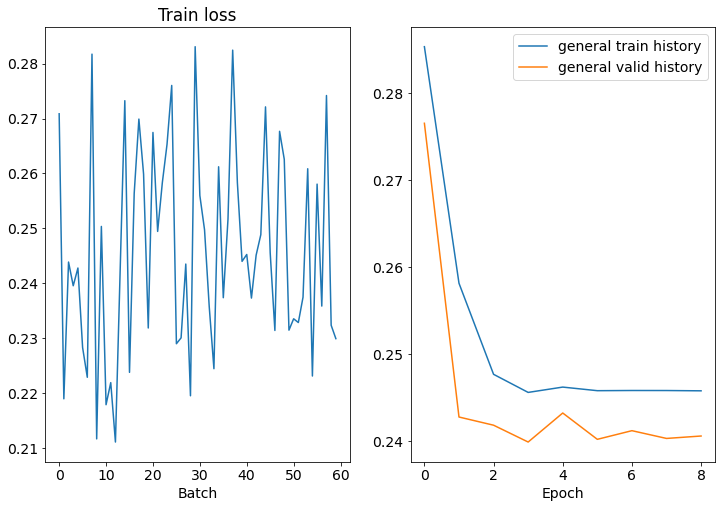

Epoch: 10 | Time: 0m 16s
	Train Loss: 0.245 | Train PPL:   1.278
	 Val. Loss: 0.241 |  Val. PPL:   1.272


In [ ]:
train(False, model, N_EPOCHS, CLIP)  # Novelty(True)_Class_Weights(False)

## Inference

In [ ]:
# create dictionary for results
results = {'BLEU_ranking = 3': {}, 'BLEU_threshold > 0': {}, 'BLEU_threshold > th': {}}

In [ ]:
def inference_summarunner(model, iterator, top_k=3):

    references = []
    predictions = []

    model.eval()
    with torch.no_grad():
        for batch in iterator:

            logits = model(batch['inputs'])
            sum_in = torch.argsort(logits, dim=1)[:, -top_k:]

            for i in range(len(batch['outputs'])):

                summary = batch['records'][i]['summary'].lower()
                pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]])

                summary, pred_summary = postprocess(summary, pred_summary)

                references.append(summary)
                predictions.append(pred_summary)

    return np.round(calc_scores(references, predictions), 3)

In [ ]:
def inference_summarunner_th(model, iterator, th):

    references = []
    predictions = []

    model.eval()
    with torch.no_grad():
        for batch in iterator:

            logits = model(batch['inputs'])
            logits = minmax_scale(logits.cpu(), feature_range=(-1, 1), axis=1, copy=True)
            logits = torch.FloatTensor(logits)

            for i in range(len(batch['outputs'])):

                sum_in = torch.nonzero(logits[i]>th, as_tuple=True)[0]
                summary = batch['records'][i]['summary'].lower()
                pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in])

                summary, pred_summary = postprocess(summary, pred_summary)

                references.append(summary)
                predictions.append(pred_summary)

    return np.round(calc_scores(references, predictions), 3)

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))

results['BLEU_threshold > 0']['Novelty(True)_ClassWeights(False)'] = inference_summarunner_th(model, test_iterator, 0)

Count: 256
Ref: джо байден пообещал подчиниться любой повестке , в том числе вызову в сенат в рамках расследования импичмента дональда трампа . бывший вице-президент сша неожиданно сменил риторику , до этого он последовательно отказывался от дачи показаний . к слову , трамп активно выступает за допрос байдена , обвиняя демократа в страхе .
Hyp: бывший вице-президент сша джо байден заявил , что будет подчиняться любой повестке , в том числе вызову в сенат для дачи показаний по делу об импичменте президент сша дональда трампа . « прежде всего , я собираюсь подчиниться любой повестке , которая будет мне отправлена » , — сказал байден во время своего выступления в фэрфилде .
BLEU:  0.45324373903883597


In [ ]:
results['BLEU_threshold > th']['Novelty(True)_ClassWeights(False)'] = inference_summarunner_th(model, test_iterator, 0.03)

Count: 256
Ref: магазины и сайты объявлений зафиксировали рост спроса на товары для спорта и фитнеса — сезонный всплеск продаж оказался даже выше уровня прошлого года . на занятиях спортом благотворно сказалась эпидемия коронавируса : посещаемость фитнес-клубов выросла . это может быть связано с тем , что многие работодатели разрешили работать удаленно . наплыв клиентов наблюдается и в фитнес-клубах : в этом , отчасти , виноват коронавирус , считают эксперты .
Hyp: россияне начали активнее готовиться к лету . за первые три дня весны продажи спортивных товаров в россии выросли почти на треть ( 28 % ) , рассказали « газете . ru » в операторе фискальных данных « платформа офд » .
BLEU:  0.48026976339811195


In [ ]:
results['BLEU_ranking = 3']['Novelty(True)_ClassWeights(False)'] = inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: президент белоруссии александр лукашенко резко отреагировал на решение россии закрыть границу с республикой из-за пандемии коронавируса . по его словам , еще стоит подумать , кто от кого должен закрывать свои пропускные пункты . лукашенко заметил , что ситуация с распространением заболевания в белоруссии не настолько критична , как в россии , которая якобы « вся полыхает от коронавируса » .
Hyp: белорусский лидер александр лукашенко в ответ на заявление российских властей о закрытии границы с республикой из-за распространения коронавируса , заявил , что в его стране ситуация с пандемией намного спокойней , чем в россии . « дошло до того , что наша родная россия — подчеркиваю — закрыла границу с беларусью » , — приводит слова лукашенко « sputnik беларусь » . он добавил , что если в его стране относительно спокойная обстановка , то россия якобы « вся полыхает от коронавируса » .
BLEU:  0.44854926516912624


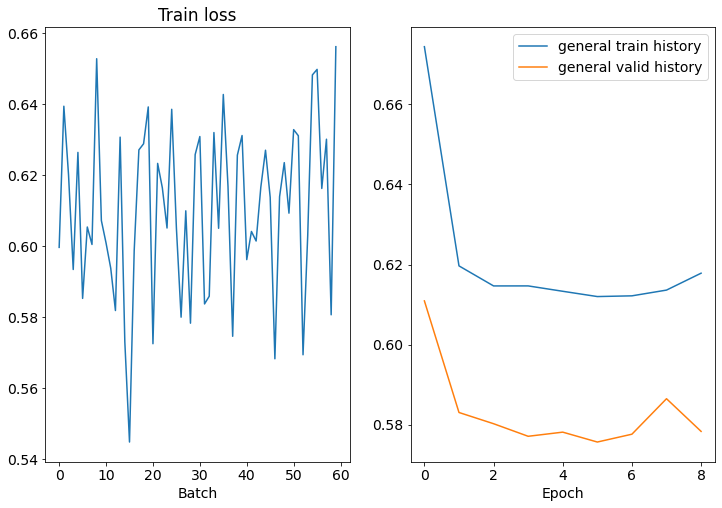

Epoch: 10 | Time: 0m 16s
	Train Loss: 0.611 | Train PPL:   1.842
	 Val. Loss: 0.580 |  Val. PPL:   1.785


In [ ]:
model = SentenceTaggerRNN(vocab_size).to(device)
train(True, model, N_EPOCHS, CLIP)  # Novelty(True)_Class_Weights(True)

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))

results['BLEU_threshold > 0']['Novelty(True)_ClassWeights(True)'] = inference_summarunner_th(model, test_iterator, 0)

Count: 256
Ref: в норвегии выступают против продления санкций в адрес москвы . ограничения приносят многомиллионные убытки европейскому бизнесу , хотя должны были бить по россии , утверждает глава совета самой крупной части страны рагнхильд вассвик . между тем россияне также платят за санкции из своего кармана и теряют около 500 млрд рублей в год .
Hyp: глава губернского совета финнмарка , которая считается самой северной и крупной административно-территориальной единицей норвегии , рагнхильд вассвик выступила за отмену санкций в отношении россии . свое мнение она высказала в статье для издания ifinnmark . по словам вассвик , прежде всего санкции затрагивают двухстороннее сотрудничество , а потому влияют на норвежских представителей бизнеса .
BLEU:  0.4489212316324451


In [ ]:
results['BLEU_threshold > th']['Novelty(True)_ClassWeights(True)'] = inference_summarunner_th(model, test_iterator, 0.056)

Count: 256
Ref: судя по данным центробанка , активнее всего в нашу страну вкладывают инвесторы из кипра , нидерландов и люксембурга . никто не обманывается , что в основном это российские бизнесмены . таким образом им удается платить меньше налогов . но это не главное . предприниматели также хотят защитить свои активы . часть российского уголовного кодекса специально написана так , чтобы « кошмарить » наш бизнес , говорят эксперты .
Hyp: больше всего инвестиций в россию приходит из трех стран — кипра ( почти 160 млрд рублей ) , нидерландов ( 56 млрд рублей ) , люксембурга ( 50 млрд рублей ) и багам ( 29 млрд рублей ) . всего , по данным на 1 июля , в нашу страну было направлено из стран-инвесторов 537 млрд рублей .
BLEU:  0.48377249861859606


In [ ]:
results['BLEU_ranking = 3']['Novelty(True)_ClassWeights(True)'] = inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: жительница санкт-петербурга , у которой врачи заподозрили коронавирус , сбежала из больницы , взломав замок . сейчас городской комитет по здравоохранению угрожает ей административной ответственностью , однако сама пациентка уверена — ее удерживали в клинике незаконно . бегут из больниц не только в россии — так , не дождавшись результатов теста , две женщины в испании и австрии самовольно покинули больницы . позже они были задержаны и отправлены под контроль медиков .
Hyp: в санкт-петербурге пациентка боткинской больницы , помещенная под карантин из-за подозрения на коронавирус , взломала замок в палате и сбежала . об этом сообщает газета « петербургский дневник » со ссылкой на городской комитет по здравоохранению . как уточнили в организации , женщина была ознакомлена с предписанием главного санитарного врача по санкт-петербургу , согласно которому она должна была в течение 14 дней находиться под наблюдением врачей в больнице .
BLEU:  0.44854926516912624


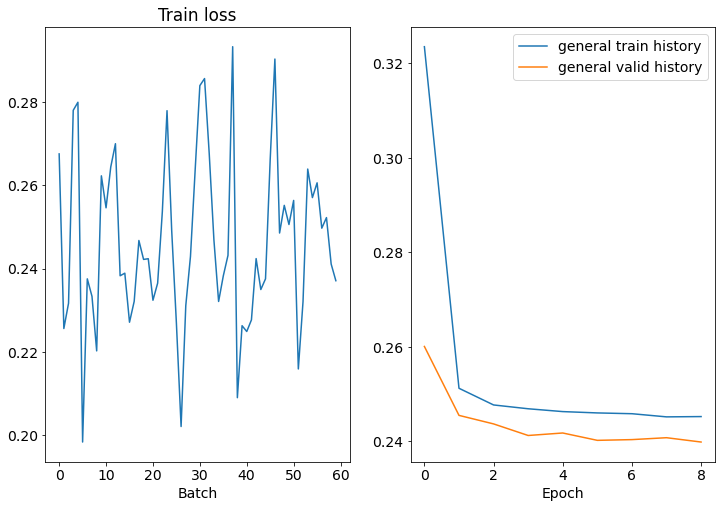

Epoch: 10 | Time: 0m 12s
	Train Loss: 0.246 | Train PPL:   1.278
	 Val. Loss: 0.240 |  Val. PPL:   1.271


In [ ]:
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
train(False, model, N_EPOCHS, CLIP)  # Novelty(False)_Class_Weights(False)

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))

results['BLEU_threshold > 0']['Novelty(False)_ClassWeights(False)'] = inference_summarunner_th(model, test_iterator, 0)

Count: 256
Ref: избранный 5 февраля глава правительства тюрингии томас кеммерих принял решение подать в отставку из-за того , что в ходе голосования за место премьера его кандидатура одержала победу благодаря поддержке правопопулистской « альтернативы для германии » . теперь его партия подаст заявку на роспуск парламента . победа кеммириха стала потрясением для всей германии из-за того , что вместе с адг политика поддержала хдс , для которой сотрудничество с правыми силами всегда было недопустимо .
Hyp: новый премьер-министр федеральной земли тюрингия на востоке германии томас кеммерих продержался на своем посту меньше суток . свободная демократическая партия , членом которой он является , объявила в twitter , что кеммерих сложит полномочия , чтобы смыть « позорное пятно » поддержки правопопулистской « альтернативы для германии » ( адг ) .
BLEU:  0.4801378209540726


In [ ]:
results['BLEU_threshold > th']['Novelty(False)_ClassWeights(False)'] = inference_summarunner_th(model, test_iterator, -0.002)

Count: 256
Ref: контракты с российским « газпромом » подписали пять украинских компаний . прямые поставки газа на украину должны начаться с 1 января 2020 года . ранее « газпром » и « нафтогаз » согласовали контракт на транзит топлива сроком на пять лет . за этот срок российская компания перекачает через украину 225 млрд кубов газа .
Hyp: пять украинских компаний подписали контракт с « газпромом » на поставки газа с 1 января 2020 года , сообщает liga . net со ссылкой на информированные источники на нефтегазовом рынке . названия компаний и объемы поставок газа не уточняются .
BLEU:  0.48022013078758063


In [ ]:
results['BLEU_ranking = 3']['Novelty(False)_ClassWeights(False)'] = inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: 30 лет назад драматург вацлав гавел был избран первым президентом чехословакии . до этого он не имел к политике никакого отношения , но благодаря своей критике властей стал моральным авторитетом для всей страны . возглавив « бархатную революцию » , гавел объединил разные политические силы . при этом во время своего президентства он активно продвигал курс в нато и даже поддержал операцию против югославии .
Hyp: 29 декабря 1989 года к власти в чехословакии пришел драматург вацлав гавел — известный критик социалистического строя . человек , не имевший , по сути , никакого политического опыта , стал первым президентом посткоммунистической чехословакии , а потом — после распада чсср — первым президентом чехии . во время « бархатной революции » — массовых мирных выступлений граждан — именно гавел становится главным лидером протеста .
BLEU:  0.44854926516912624


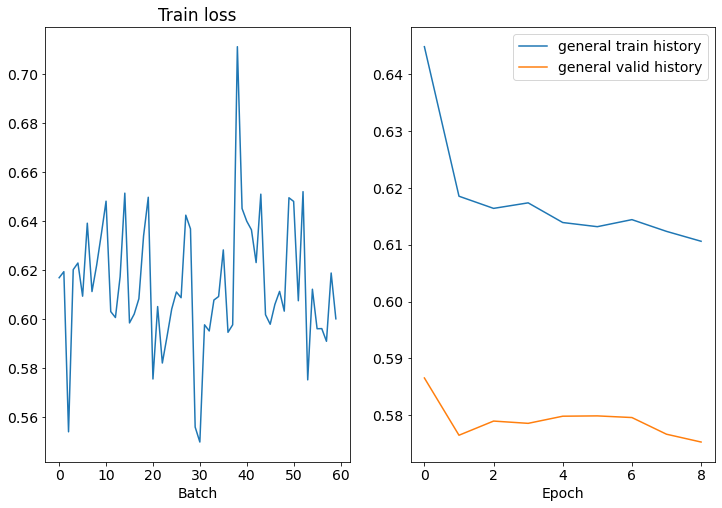

Epoch: 10 | Time: 0m 11s
	Train Loss: 0.612 | Train PPL:   1.845
	 Val. Loss: 0.575 |  Val. PPL:   1.778


In [ ]:
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
train(True, model, N_EPOCHS, CLIP)  # Novelty(False)_Class_Weights(True)

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))

results['BLEU_threshold > 0']['Novelty(False)_ClassWeights(True)'] = inference_summarunner_th(model, test_iterator, 0)

Count: 256
Ref: журналист львовского интернет-издания павел зубюк сравнил киев и москву . по его словам , украинская столица является « второсортной » версией москвы , только меньшей по размеру . зубюк считает , что если новое руководство москвы решает проблемы мегаполиса и улучшает инфраструктуру , то киевские власти по-прежнему идут в « пагубном » направлении развития столицы .
Hyp: львовский журналист павел зубюк сравнил москву и киев , назвав при этом столицу украины « второсортной » москвой , передает риа « новости » . « киев не просто идет вслед за москвой , он от нее сильно отстает . можно даже сказать точнее : киев — это такая второсортная , меньшая по размеру москва » , — считает журналист интернет-издания zahid . net .
BLEU:  0.4470492963746375


In [ ]:
results['BLEU_threshold > th']['Novelty(False)_ClassWeights(True)'] = inference_summarunner_th(model, test_iterator, 0.164)

Count: 256
Ref: в красноярске задержали подозреваемого в убийстве 29-летней бьюти-массажистки — им оказался кинолог фсин , работающий в местной колонии строгого режима . по версии регионального ск , мужчина расправился с женщиной на территории заброшенной военной части — он несколько раз ударил жертву арматурой , после чего засыпал мусором и скрылся . как пояснила сестра погибшей , массажистка приходилась сотруднику фсин любовницей , и у них регулярно возникали конфликты .
Hyp: 31-летнего кинолога фсин задержали по подозрению в убийстве 29-летней бьюти-массажистки из красноярска галины миниенко , сообщает региональный следственный комитет . по предварительным данным , девушка приходилась предполагаемому злоумышленнику любовницей , пишет сайт kp . ru . согласно материалам дела , 15 ноября она выехала из красноярска в поселок арейское на своем автомобиле – там миниенко намеревалась выяснить отношения со своим возлюбленным .
BLEU:  0.4858632710574743


In [ ]:
results['BLEU_ranking = 3']['Novelty(False)_ClassWeights(True)'] = inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: в современном мире быть веганом или вегетарианцем гораздо проще , чем много лет назад . сейчас , когда всевозможные приложения для поиска растительной еды уже придуманы , энтузиасты принялись разрабатывать вспомогательные девайсы для отказа от мяса , вводить веганскую криптовалюту и делать кожу из мицелия .
Hyp: британские ученые придумали девайс , который поможет легче отказаться от мяса тем , кто решил стать веганом или вегетарианцем . они создали пластырь , который очень похож на никотиновый , однако работает совершенно по другому принципу . об этом сообщает телеканал fox news .
BLEU:  0.44854926516912624


## Вывод:

Полученные результаты представлены в таблице:

In [ ]:
result_df = pd.DataFrame(results)
result_df

,BLEU_ranking = 3,BLEU_threshold > 0,BLEU_threshold > th
Novelty(True)_ClassWeights(False),0.449,0.453,0.480
Novelty(True)_ClassWeights(True),0.449,0.449,0.484
Novelty(False)_ClassWeights(False),0.449,0.480,0.480
Novelty(False)_ClassWeights(True),0.449,0.447,0.486


Использование novelty и Class Weights не влияет на результат в случае ранжирования логитов при выборе первых трёх предложений в качестве summary. Во всех случаях получаем значение BLEU = 0.449 Изменение количества предложений как в сторону увеличения так и уменьшения негативно сказывается на результате. Для отсечки логитов выше определённого порога было выполнено предварительное нормирование логитов в диапазоне от -1 до 1. Отсечка логитов > 0 позволяет повысить BLEU для некоторых моделей. Максимальное значение BLEU достигается при ручном подборе отсечки, практически во всех случаях это значение чуть больше нуля. Для каждой модели отсечка подбиралась индивидуально, что позволило получить значение BLEU = 0.48 и выше для всех моделей. Повышение качества достигается за счёт того, что summary включает в себя разное количество предложений в зависимости от текста. Максимальное значение BlEU = 0.486 удалось достичь с помощью модели с отключённым novelty и с использованием ClassWeights. В целом, можно сказать, что использование ClassWeights положительно влияет на результат в случае ручного подбора отсечки логитов. Значимого положительного влияния novelty на качество BLEU в этом случае выявлено не было.